In [1]:
cd ../

C:\Users\teruto\Desktop\sourcecode\livedoor-news-clustering


In [2]:
cd data

C:\Users\teruto\Desktop\sourcecode\livedoor-news-clustering\data


In [3]:
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math
from sklearn.linear_model import LogisticRegression

In [4]:
#ファイル読み込み
train_df = pd.read_csv('./preprosessing_train.csv')
X_df_train = train_df[['text_length', 'is_year', 'is_month', 'is_date',
       'is_time', 'num_hatena', 'num_bikkuri', 'is_eiga', 'is_henkakko',
       'is_normalkakko', 'is_whitekakko', 'is_vol', 'is_sports',
       'text_del_one']]
Y_df_train = train_df["flg"].astype(np.int64)
X_train =  X_df_train.values
t_train = Y_df_train.values

dev_df = pd.read_csv('./preprosessing_dev.csv')
X_df_dev = dev_df[['text_length', 'is_year', 'is_month', 'is_date',
       'is_time', 'num_hatena', 'num_bikkuri', 'is_eiga', 'is_henkakko',
       'is_normalkakko', 'is_whitekakko', 'is_vol', 'is_sports',
       'text_del_one']]
Y_df_dev = dev_df["flg"].astype(np.int64)
X_valid =  X_df_dev.values
t_valid = Y_df_dev.values

test_df = pd.read_csv('./preprosessing_test.csv')
X_df_test = test_df[['text_length', 'is_year', 'is_month', 'is_date',
       'is_time', 'num_hatena', 'num_bikkuri', 'is_eiga', 'is_henkakko',
       'is_normalkakko', 'is_whitekakko', 'is_vol', 'is_sports',
       'text_del_one']]
Y_df_test = test_df["flg"].astype(np.int64)
X_test =  X_df_test.values
t_test = Y_df_test.values

In [5]:

#特徴量配列
X_train_feat = X_train[:,:-1]
X_valid_feat = X_valid[:,:-1]
X_test_feat = X_test[:,:-1]
X_train_feat.shape

(5000, 13)

In [6]:
#特徴量標準化
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
ss = MinMaxScaler()
X_train_feat_ss = ss.fit_transform(X_train_feat)
X_valid_feat_ss = ss.transform(X_valid_feat)
X_test_feat_ss = ss.transform(X_test_feat)

In [7]:
#文字カラムに対する欠損値削除
X_train_del_one = X_train[:,-1]
for idx in range(len(X_train_del_one)):
    if type(X_train_del_one[idx]) is float:
        X_train_del_one[idx] = " " 

X_valid_del_one = X_valid[:,-1]
for idx in range(len(X_valid_del_one)):
    if type(X_valid_del_one[idx]) is float:
        X_valid_del_one[idx] = " "
        
X_test_del_one = X_test[:,-1]
for idx in range(len(X_test_del_one)):
    if type(X_test_del_one[idx]) is float:
        X_test_del_one[idx] = " "

In [8]:
#単語ベクトル化(最大値、最小値を設定した)
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
cv = TfidfVectorizer(min_df=3/5000, max_df=3800/5000)
#cv = TfidfVectorizer()
X_train_cv = cv.fit_transform(X_train_del_one)
X_valid_cv = cv.transform(X_valid_del_one)
X_test_cv = cv.transform(X_test_del_one)

In [9]:
#文字配列と特徴量の配列を結合する
X_train = np.concatenate([X_train_cv.toarray(),X_train_feat_ss],1)
X_valid = np.concatenate([X_valid_cv.toarray(),X_valid_feat_ss],1)
X_test = np.concatenate([X_test_cv.toarray(),X_test_feat_ss],1)

In [10]:
#型変換
X_train = X_train.astype(np.float32)
X_valid = X_valid.astype(np.float32)
X_test = X_test.astype(np.float32)
t_train = t_train.astype(np.int32)
t_valid = t_valid.astype(np.int32)
t_test = t_test.astype(np.int32)

In [11]:

#スパース配列に変換
from scipy.sparse import csr_matrix
X_train_csr = csr_matrix(X_train)
X_valid_csr = csr_matrix(X_valid)
X_test_csr = csr_matrix(X_test)

In [12]:
#混合行列
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score ,precision_score, recall_score,f1_score
import seaborn as sns
def result_heatmap(Y_test,Y_pred):
    print("正解率:"+str(accuracy_score(Y_test, Y_pred)))
    cm = confusion_matrix(Y_test, Y_pred)
    #print(cm)
    sns.heatmap(cm,annot=True, cmap='Blues')

In [13]:
#PCA
from sklearn.decomposition import  TruncatedSVD 
pca =  TruncatedSVD(500)
X_train_pca = pca.fit_transform(X_train_csr) 
X_valid_pca = pca.transform(X_valid_csr)
X_test_pca = pca.transform(X_test_csr)

In [14]:
#ロジスティック
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
pipe_lr = make_pipeline(
                       LogisticRegression(penalty="l2",C=100,random_state=1))

c:\users\teruto\desktop\sourcecode\livedoor-news-clustering\venv\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


正解率:0.754


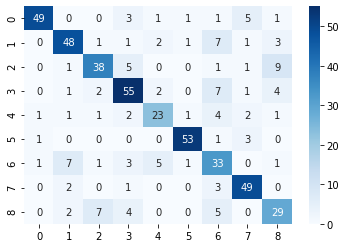

In [15]:

pipe_lr.fit(X_train_pca,t_train)
y_pred =  pipe_lr.predict(X_test_pca)
result_heatmap(t_test,y_pred)

In [17]:
proba = pipe_lr.predict_proba(X_test_pca)
np.savetxt('./ensemble/logistic_1.csv',proba,delimiter=',')